In [85]:
import spacy
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import json
import os
import gender_guesser.detector as gender
import seaborn as sns

# Load spaCy with GloVe vectors
nlp = spacy.load('en_core_web_md')  # en_core_web_md includes GloVe vectors


Simple toy example where we selected some films that have good and bad female representations, also added some of our favorite movies.

In [33]:
movie_dict={
            481605:"Batman Begins",
            6009939:"Interstellar",
            2750041:"Memento",
            2809621:"Prestige",
            106117:"Thelma and Louise",
            2236472:"Transformers",
            431014:"Big fish",
            28728982:"Mulan",
            26581256:"The Twilight Saga: Breaking Dawn - Part 1",
            13229264:"He's Just Not That Into You",
            17112291:"Confessions of a Shopaholic",
            17323415:"Bride Wars",
            883489:"Mona Lisa Smile",
            667371:"Harry Potter and the Prisoner of Azkaban",
            1128561:"Crossroads",
            }


This is the structure of the data we extracted from CoreNLP processed plot summaries

```
dependencies[character] = {
        'actions_taken': actions_taken,
        'actions_received': actions_received,
        'possessions': possessions,
        'descriptions': descriptions
    }
```

In [34]:
movies=pd.read_pickle("dataset/characters.pkl")

In [36]:
gender_detector = gender.Detector()

character_vectors=[]
character_entries=[]

for movie_id in movie_dict:
    movie=movies.get(str(movie_id))
    if movie:
        for character_name in movie:
            character=movie[character_name]
            character_vector=[]
            
            for word in set(character["actions_taken"]+character["descriptions"]):
                character_vector.append(nlp(word).vector)
            fin_vec=np.sum(np.array(character_vector),axis=0) #Just simple summation of all word wectors
            if fin_vec.shape==(300,):
                character_entries.append(
                    {
                        "character_name":character_name,
                        "movie_id":movie_id,
                        "movie_name":movie_dict[movie_id],
                        "gender":gender_detector.get_gender(character_name), #for now, we use a library for guessing female characters
                        "actions_taken":character["actions_taken"],
                        "descriptions":character["descriptions"]
                    }
                )
                character_vectors.append(fin_vec)
            else:
                continue

character_df=pd.DataFrame(character_entries)
character_embeddings=np.array(character_vectors)

In [38]:
character_df

,character_name,movie_id,movie_name,gender,actions_taken,descriptions
0,Bruce,481605,Batman Begins,male,"[intend, confront, decide, learn, refuse, burn...",[young]
1,Falcone,481605,Batman Begins,unknown,"[import, insane]","[untouchable, crime, boss]"
2,Ducard,481605,Batman Begins,unknown,"[offer, confront]",[unconscious]
3,Pennyworth,481605,Batman Begins,unknown,"[take, save, rescue]",[]
4,Crane,481605,Batman Begins,unknown,"[expose, reveal, dump, reveal, declare]",[corrupt]
...,...,...,...,...,...,...
94,Ben,1128561,Crossroads,male,"[reveal, be, assassin, be, grow, stay]",[]
95,Lucy,1128561,Crossroads,female,"[friend, friend, turn, teenager, want, want, b...",[]
96,Caroline,1128561,Crossroads,female,"[reveal, marry, have, reveal, want, mistake]",[mother]
97,Dylan,1128561,Crossroads,mostly_male,[kit],[]


In [63]:
tsne = TSNE(n_components=2, random_state=42,perplexity=30,init="pca")
char_tsne = tsne.fit_transform(character_embeddings)

In [64]:
female_char_index=character_df[(character_df["gender"]=='female') | (character_df["gender"]=='mostly_female')].index
male_char_index=character_df[(character_df["gender"]=='male') | (character_df["gender"]=='mostly_male')].index

non_amb_char_index=character_df[~((character_df["gender"]=='unknown') | (character_df["gender"]=='andy'))].index

In [ ]:
non_amb_char_index=character_df[~((character_df["gender"]=='unknown') | (character_df["gender"]=='andy'))].index

comparable_df=character_df.iloc[non_amb_char_index].copy()

def binarize_gender(row):
    if row["gender"] in ["female","mostly_female"]:
        return "female"
    else:
        return "male"

comparable_df["gender"]=comparable_df.apply(binarize_gender,axis=1)
comparable_embed=char_tsne[non_amb_char_index]

comparable_df["x"]=comparable_embed[:,0]
comparable_df["y"]=comparable_embed[:,1]

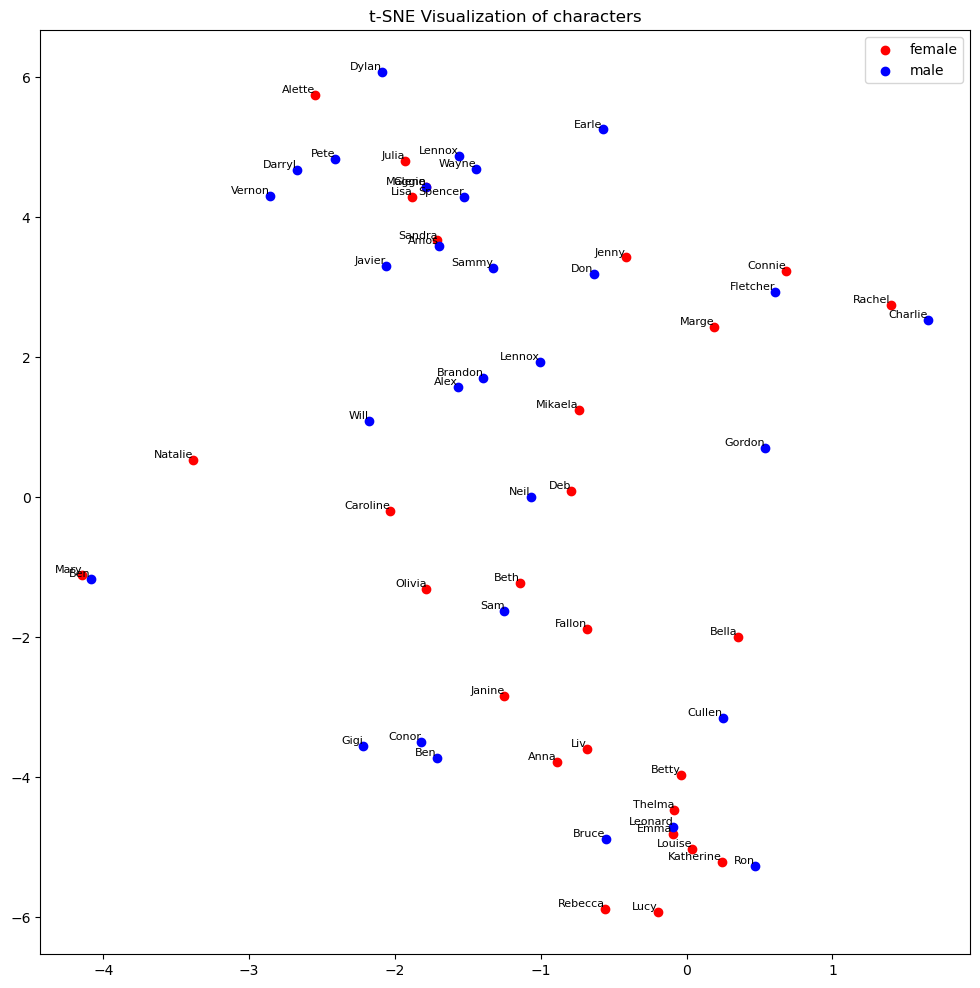

In [71]:
fig= plt.figure(figsize=(12, 12))

plt.scatter(char_tsne[female_char_index, 0], char_tsne[female_char_index, 1],c="r",label="female")
plt.scatter(char_tsne[male_char_index, 0], char_tsne[male_char_index, 1],c="b",label="male")
#plt.scatter(X_tsne[other_chars, 0], X_tsne[other_chars, 1],c="g")

for label, xi, yi in zip(character_df.iloc[non_amb_char_index]["character_name"],char_tsne[non_amb_char_index, 0], char_tsne[non_amb_char_index, 1]):
    plt.text(xi, yi, label, fontsize=8, ha='right', va='bottom')

plt.title('t-SNE Visualization of Character Embeddings')

plt.legend()
plt.show()

<AxesSubplot:xlabel='x', ylabel='y'>

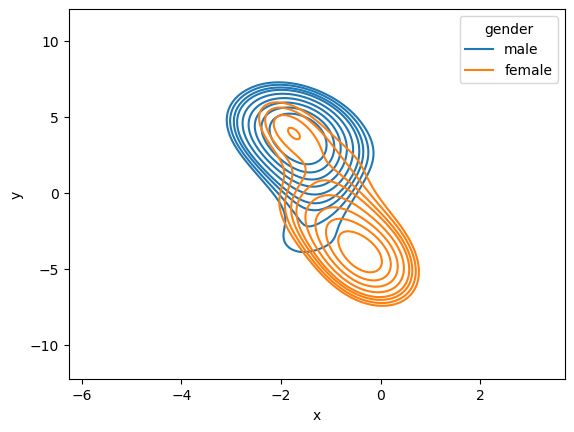

In [87]:

comparable_df=character_df.iloc[non_amb_char_index].copy()

def binarize_gender(row):
    if row["gender"] in ["female","mostly_female"]:
        return "female"
    else:
        return "male"

comparable_df["gender"]=comparable_df.apply(binarize_gender,axis=1)
comparable_embed=char_tsne[non_amb_char_index]

comparable_df["x"]=comparable_embed[:,0]
comparable_df["y"]=comparable_embed[:,1]

sns.kdeplot(data=comparable_df, x="x", y="y", hue="gender",levels=10, thresh=0.5)